In [190]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, math

In [192]:
Opis eksperymentu

####
Problem:
    
Celem eksperymentu było zrównoleglenie sortowania kubełkowego i ocena skalowalności problemu.

####
Infrastruktura:
    
Klaster obliczeniowy Zeus, 1 węzeł, cpus-per-task=12

####
Opis algorytmów:
    
Problem sortowania kubełkowego podzielono na cztery części, z których każdą zrównoleglono:
1. Generowanie tablicy wejściowej
2. Rozdzielanie tablicy wejściowej do kubełków
3. Sortowanie poszczególnych kubełków
4. Scalanie kubełków do tablicy wyjściowej

Zaimplementowane zostały dwie wersje algorytmu sortowania. Każda z nich w inny sposób realizuje części 2-4.

Pierwsza z nich ('sorting.cpp') zakłada wspólną pulę kubełków, do której piszą wszystkie wątki programu. 
Po rozdzieleniu tablicy do wspólnych kubełków wykonuje się ich sortowanie wyników i scalanie do tablicy wyjściowej.

Druga wersja ('sorting_merging.cpp') zakłada, że każdy wątek programu posiada odrębny zestaw kubełków, 
do którego wpisuje elementy z tablicy wejściowej. Kubełki są sortowane. 
Elementy z kubełków każdego wątku zawierającego ten sam przedział liczbowy zapisywane są do kolejki priorytetowej.
Kolejki priorytetowe reprezentujące kolejne przedziały są scalane do tablicy wyjściowej.

Implementacja:
Kod został napisany w języku C++. Do zrównoleglenia problemu sortowania wykorzystano mechanizmy OpenMP:
- omp_get_wtime() do pomiaru czasu wykonania,
- omp_set_num_threads() do ustawienia liczby wątków,
- omp locks do zarządzania dostępem do wspólnych kubełków w przypadku pierwszej wersji algorytmu,
- dyrektywy pragma omp for / parallel for / parallel for num_threads(number_of_threads) 
  do definiowana części równoległych programu.

####
Przebieg eksperymentu:

Zmierzono czas wykonania programu sekwencyjnego dla 1 mln 10 mln elementów w tablicy wejściowej 
z zakresu 0-100, 0-1000 i 0-10000, dla kolejno 100, 1000 i 10000 kubełków.
Następnie zmierzono czas wykonania programu zrównoleglonego dla tych samych parametrów z wykorzystaniem 2 - 8 wątków. 
Program zrównoleglony uruchomiono w wersji skalowalnej i nieskalowalnej. 

W wersji skalowalnej każdy z dostępnych wątków obliczał 1 mln i 10 mln punktów.
W wersji nieskalowalnej cały program obliczał 1 mln i 10 mln punktów, 
a więc każdy wątek miał do obliczenia wspomnianą liczbę punktów podzieloną przez liczbę wszystkich wątków.

Dla określenia wydajności programu równoległego użyto metryki speedup.

####
Wyniki eksperymentu:
Czasy wykonania znajdują się w folderze Dane_pomiarowe dołączonym do rozwiązania.
Wykresy czasu wykonania i speedupu znajdują się w folderze Wykresy dołączonym do rozwiązania.

####
Wnioski:

In [213]:
NUMBER_OF_THREADS = 12

file2_scalable = pd.read_csv("openmp_sorting/zeus/results_scalable.txt")
file2_nonscalable = pd.read_csv("openmp_sorting/zeus/results_non-scalable.txt")
file3_scalable = pd.read_csv("openmp_sorting/zeus/results_merging_scalable.txt")
file3_nonscalable = pd.read_csv("openmp_sorting/zeus/results_merging_non-scalable.txt")

In [214]:
def plot_time(data_file_2, data_file_3, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data_2 = data_file_2.query(query)['time'].values
    filtered_data_3 = data_file_3.query(query)['time'].values
    
    plt.plot(np.arange(2, NUMBER_OF_THREADS+1), filtered_data_2[1:], 'ro')
    plt.plot(np.arange(2, NUMBER_OF_THREADS+1), filtered_data_3[1:], 'bo')

    plt.plot()
    plt.xlabel("Number of threads")
    plt.ylabel("Execution time (s)")
    plt.title("EXECUTION TIME" + "\n Number of points: " + str(number_of_points) +  "\n Number of buckets: " + str(number_of_buckets) + "\n Range of numbers: " + str(range_of_numbers) + "\n"+ if_scalable)
    plt.legend(["Algorithm 2", "Algorithm 3"])
    plt.show()

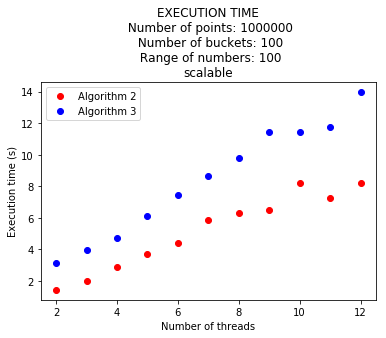

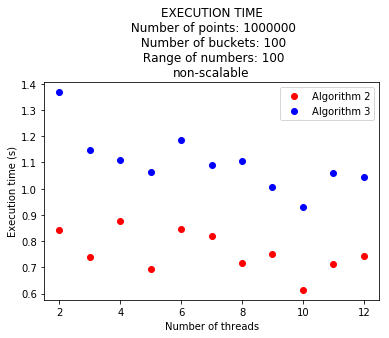

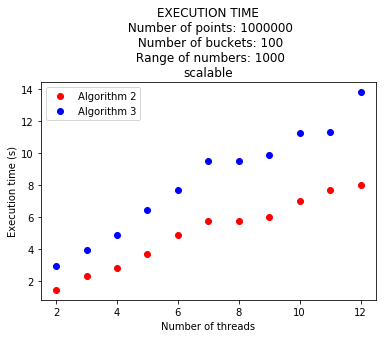

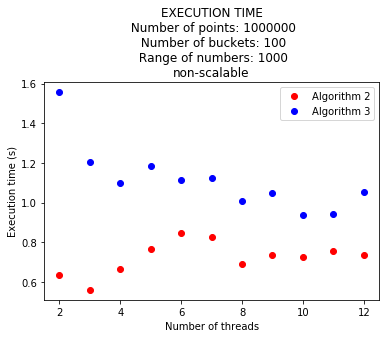

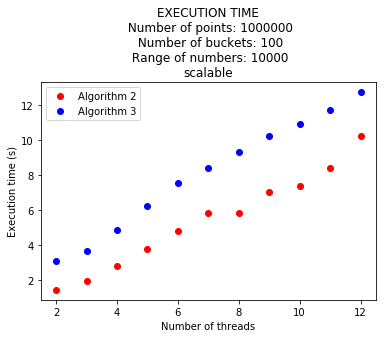

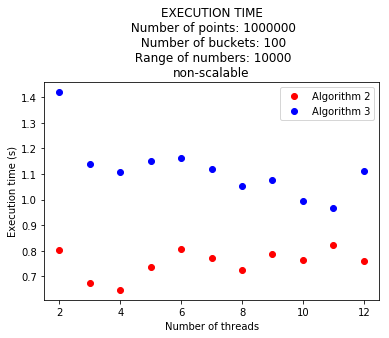

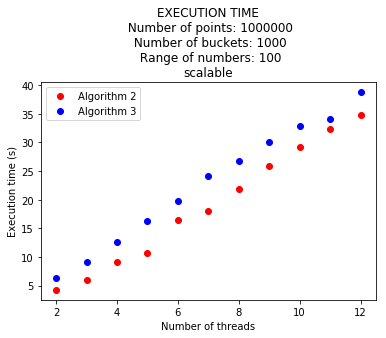

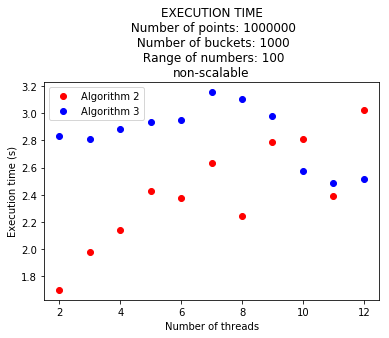

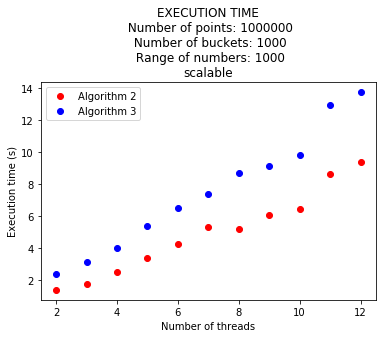

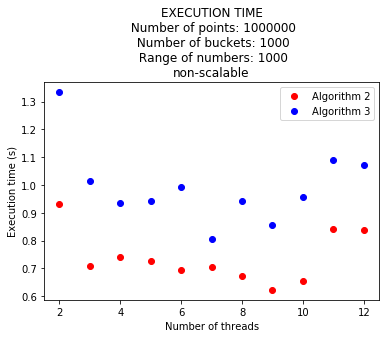

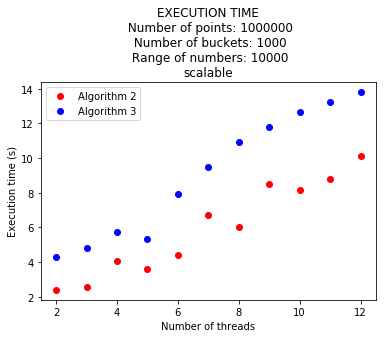

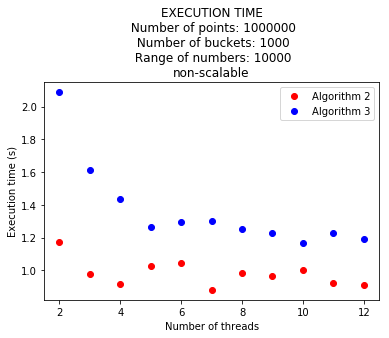

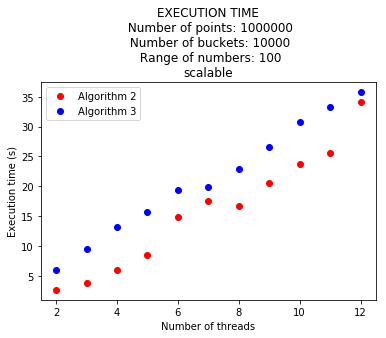

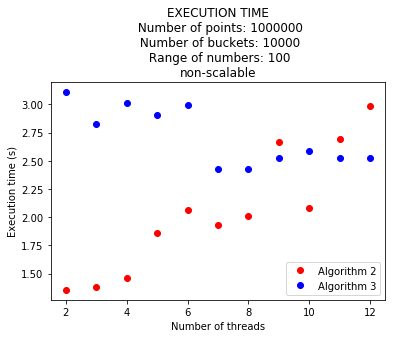

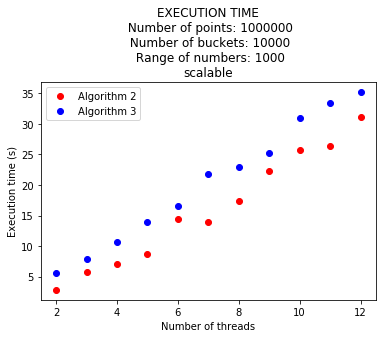

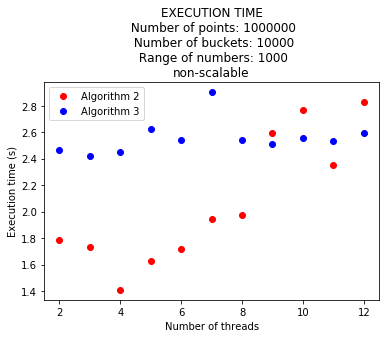

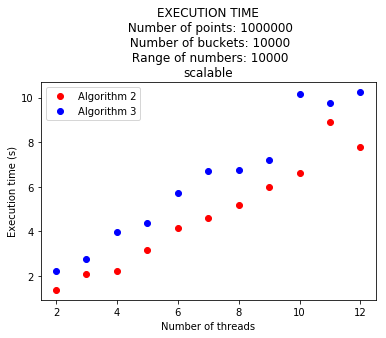

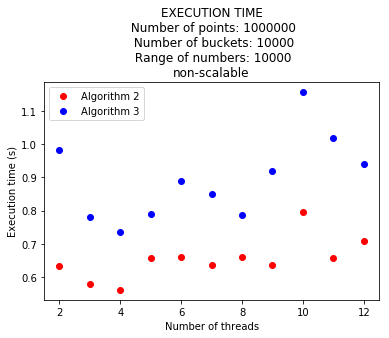

In [215]:
points = [1000000]
buckets = [100,1000,10000]
ranges = [100,1000,10000]

for p in points:
    for b in buckets:
        for r in ranges:
            plot_time(file2_scalable, file3_scalable, p, b, r, "scalable")
            plot_time(file2_nonscalable, file3_nonscalable, p, b, r, "non-scalable")

In [216]:
def speedup_scalable(sequence, time, cores):
    return sequence / time * cores

def speedup_nonscalable(sequence, time): 
    return sequence / time

In [217]:
def plot_speedup(data_file_2, data_file_3, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data_2 = data_file_2.query(query)
    filtered_data_3 = data_file_3.query(query)
    
    times_2 = filtered_data_2['time'].values
    times_3 = filtered_data_3['time'].values
    sequence_2 = times_2[0]
    sequence_3 = times_3[0]
    speedup_values_2 = []
    speedup_values_3 = []

    if if_scalable == "scalable":
        for i in range (1, NUMBER_OF_THREADS):
            speedup_values_2.append(speedup_scalable(sequence_2, times_2[i], i+1))
            speedup_values_3.append(speedup_scalable(sequence_3, times_3[i], i+1))
    else:
        for i in range (1, NUMBER_OF_THREADS):
            speedup_values_2.append(speedup_nonscalable(sequence_2, times_2[i]))
            speedup_values_3.append(speedup_nonscalable(sequence_3, times_3[i]))
    
    x = np.arange(2, NUMBER_OF_THREADS+1)
    plt.plot(x, speedup_values_2, 'ro')
    plt.plot(x, speedup_values_3, 'bo')
    plt.plot(x,x, 'g--')
    
    plt.xlabel("Number of threads")
    plt.ylabel("Speedup")
    plt.title("SPEEDUP \n Number of points: " + str(number_of_points) +  "\n Number of buckets: " + str(number_of_buckets) + " \n Range of numbers: " + str(range_of_numbers) + "\n"+ if_scalable)
    plt.legend(["Algorithm 2", "Algorithm 3", "Ideal speedup"])
    plt.show()

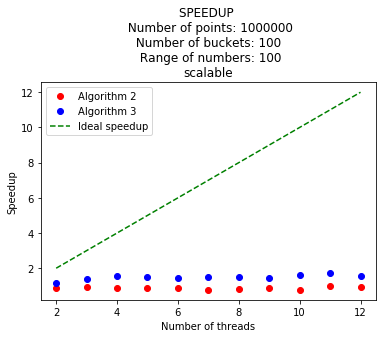

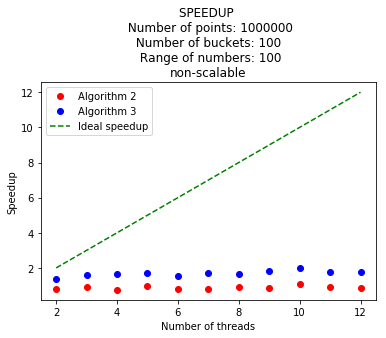

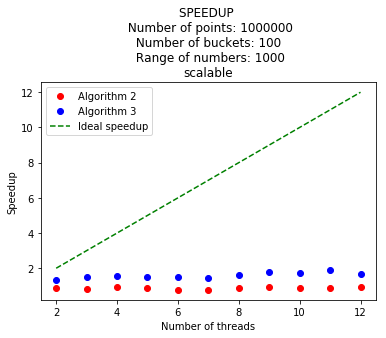

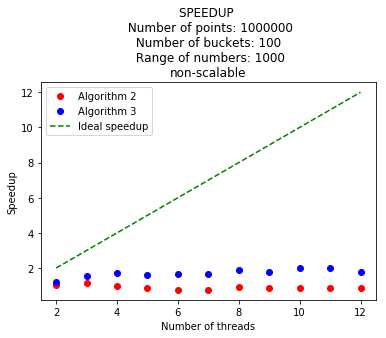

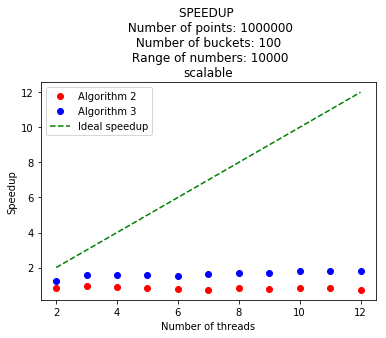

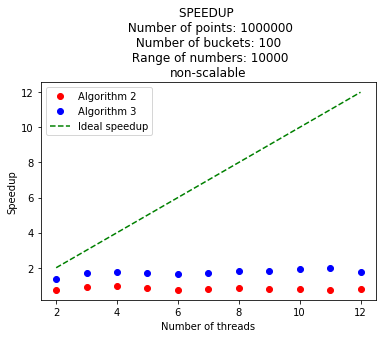

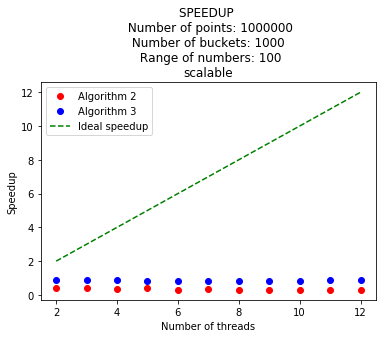

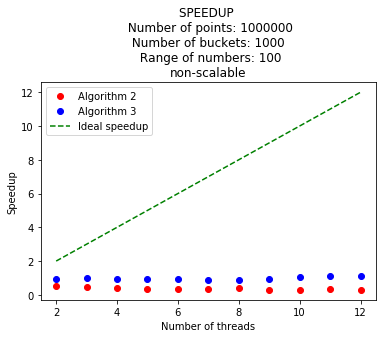

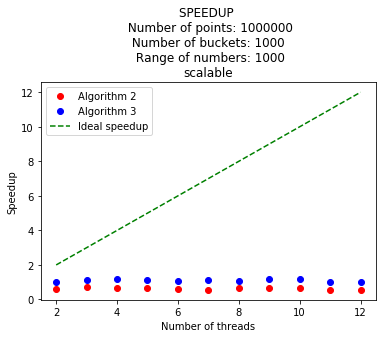

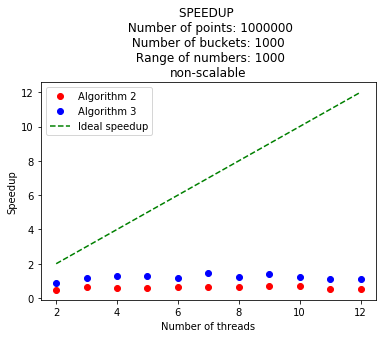

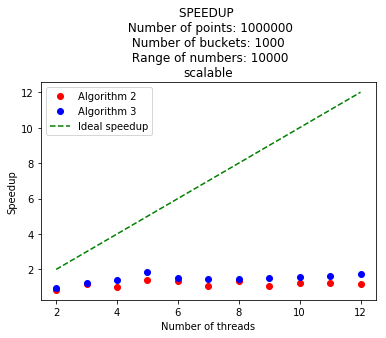

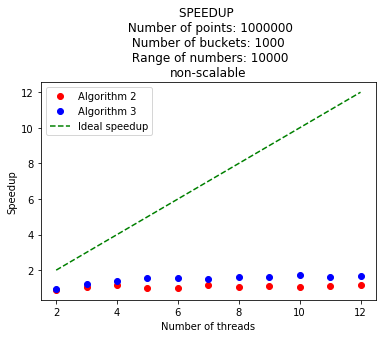

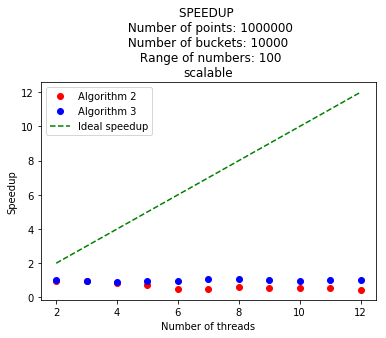

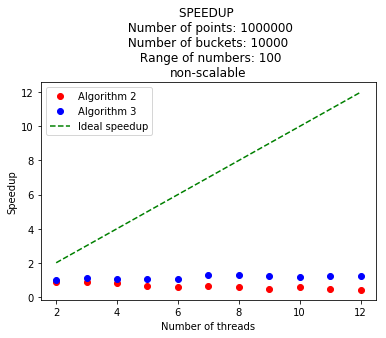

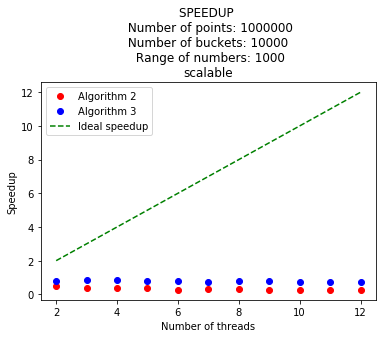

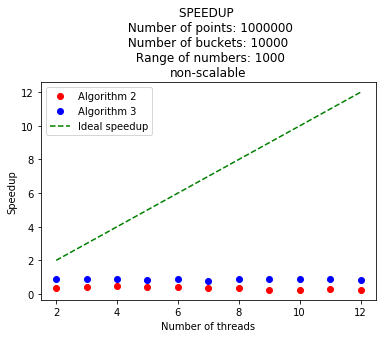

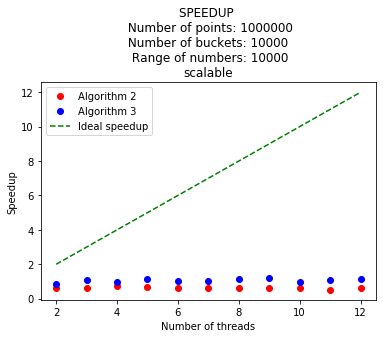

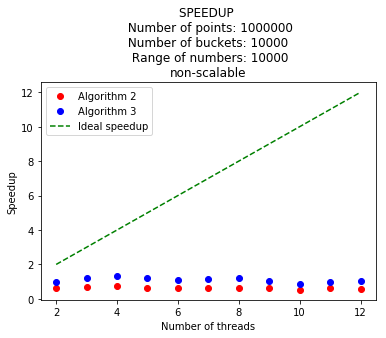

In [218]:
for p in points:
    for b in buckets:
        for r in ranges:
            plot_speedup(file2_scalable, file3_scalable, p, b, r, "scalable")
            plot_speedup(file2_nonscalable, file3_nonscalable, p, b, r, "non-scalable")

In [223]:
def analyse_speedup(data_file_2, data_file_3, if_scalable):
    speedup_mean = []
    for p in points:
        for b in buckets:
            for r in ranges:
                query = 'number_of_points==' + str(p) + ' & number_of_buckets==' + str(b) + ' & range_of_numbers==' + str(r)
                
                filtered_data_2 = data_file_2.query(query)
                filtered_data_3 = data_file_2.query(query)
    
                times_2 = filtered_data_2['time'].values
                times_3 = filtered_data_3['time'].values
                
                sequence_2 = times_2[0]
                sequence_3 = times_3[0]
                
                speedup_values_2 = []
                speedup_values_3 = []
                
                if(if_scalable=="scalable"):
                    for i in range (1, NUMBER_OF_CORES):
                        speedup_values_2.append(speedup_scalable(sequence_2, times_2[i], i+1))
                        speedup_values_3.append(speedup_scalable(sequence_3, times_3[i], i+1))
                else:
                    for i in range (1, NUMBER_OF_CORES):
                        speedup_values_2.append(speedup_nonscalable(sequence_2, times_2[i]))
                        speedup_values_3.append(speedup_nonscalable(sequence_3, times_3[i]))
                        
                
                print("points: ", p, " buckets: ", b, " range: ", r, " mean speedup: ", np.mean(speedup_values_2))
                speedup_mean.append(np.mean(speedup_values_2))
                
    print(if_scalable, "mean speedup:", np.mean(speedup_mean))

In [224]:
analyse_speedup(file2_scalable, file3_scalable, "scalable")

points:  1000000  buckets:  100  range:  100  mean speedup:  0.8682597159657199
points:  1000000  buckets:  100  range:  1000  mean speedup:  0.8423943426228994
points:  1000000  buckets:  100  range:  10000  mean speedup:  0.8425036970472769
points:  1000000  buckets:  1000  range:  100  mean speedup:  0.370750468690145
points:  1000000  buckets:  1000  range:  1000  mean speedup:  0.6506961427537489
points:  1000000  buckets:  1000  range:  10000  mean speedup:  1.1659497365380413
points:  1000000  buckets:  10000  range:  100  mean speedup:  0.7235825424256487
points:  1000000  buckets:  10000  range:  1000  mean speedup:  0.3657416318961678
points:  1000000  buckets:  10000  range:  10000  mean speedup:  0.6331177151214714
scalable mean speedup: 0.71811066589568


In [225]:
analyse_speedup(file2_nonscalable, file3_nonscalable, "non-scalable")


points:  1000000  buckets:  100  range:  100  mean speedup:  0.8336796726247343
points:  1000000  buckets:  100  range:  1000  mean speedup:  0.9152506041362727
points:  1000000  buckets:  100  range:  10000  mean speedup:  0.8269083961402985
points:  1000000  buckets:  1000  range:  100  mean speedup:  0.4044964216646826
points:  1000000  buckets:  1000  range:  1000  mean speedup:  0.6003339670975426
points:  1000000  buckets:  1000  range:  10000  mean speedup:  1.0503611089717892
points:  1000000  buckets:  10000  range:  100  mean speedup:  0.7275078948313144
points:  1000000  buckets:  10000  range:  1000  mean speedup:  0.3957757411841503
points:  1000000  buckets:  10000  range:  10000  mean speedup:  0.6630586944128366
non-scalable mean speedup: 0.7130413890070691
